In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib

In [3]:
df = pd.read_csv("predictive_maintenance.csv")

In [4]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [5]:
# Drop unnecessary columns
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Check for null values
print("Missing values:\n", df.isnull().sum())

Missing values:
 Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


In [6]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


In [7]:
# Encode 'Type' column
df = pd.get_dummies(df, columns=['Type'], drop_first=True)

# Map 'Failure Type' column to numerical labels
failure_mapping = {
    'No Failure': 0,
    'Heat Dissipation Failure': 1,
    'Power Failure': 2,
    'Overstrain Failure': 3,
    'Tool Wear Failure': 4,
    'Random Failures': 5
}
df['Failure Type'] = df['Failure Type'].map(failure_mapping)

df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,False,True
1,298.2,308.7,1408,46.3,3,0,0,True,False
2,298.1,308.5,1498,49.4,5,0,0,True,False
3,298.2,308.6,1433,39.5,7,0,0,True,False
4,298.2,308.7,1408,40.0,9,0,0,True,False


In [8]:
X = df.drop('Failure Type', axis=1)
y = df['Failure Type']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:
# --- Handle Class Imbalance with SMOTE ---
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [17]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca=pca.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Reduced features after PCA: {X_pca.shape[1]}")

Original features: 8
Reduced features after PCA: 6


In [15]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you already have your data loaded in X
# Example column order (replace with your actual columns if needed)
feature_names = [
    'Air Temperature [K]',
    'Process Temperature [K]',
    'Torque [Nm]',
    'Rotational Speed [rpm]',
    'Tool Wear [min]',
    'Type_H',
    'Type_L',
    'Type_M'
]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: {len(feature_names)}")
print(f"Reduced features after PCA: {X_pca.shape[1]}")

# Show PCA component loadings
pca_components_df = pd.DataFrame(
    pca.components_,
    columns=feature_names,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Display top contributing features per principal component
print("\nTop contributing features to each principal component:\n")
print(pca_components_df.abs().T.sort_values(by='PC1', ascending=False))  # Show PC1 dominance


Original features: 8
Reduced features after PCA: 6

Top contributing features to each principal component:

                              PC1       PC2       PC3       PC4       PC5  \
Rotational Speed [rpm]   0.608373  0.349646  0.030548  0.049270  0.017804   
Torque [Nm]              0.602129  0.329226  0.036909  0.142817  0.161267   
Process Temperature [K]  0.358089  0.601876  0.043006  0.081026  0.061056   
Air Temperature [K]      0.356278  0.606155  0.042316  0.049516  0.015768   
Type_H                   0.110072  0.182983  0.037570  0.633431  0.731872   
Type_M                   0.006195  0.041708  0.704612  0.038964  0.024327   
Type_L                   0.002604  0.053138  0.704193  0.030432  0.012767   
Tool Wear [min]          0.000119  0.040413  0.016944  0.751319  0.658261   

                              PC6  
Rotational Speed [rpm]   0.004813  
Torque [Nm]              0.004387  
Process Temperature [K]  0.016566  
Air Temperature [K]      0.006444  
Type_H            

In [16]:
# --- Compute Class Weights (for XGBoost training) ---
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_balanced), y=y_train_balanced)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

In [18]:
# --- Convert to DMatrix ---
dtrain = xgb.DMatrix(X_train_pca, label=y_train_balanced)
dtest = xgb.DMatrix(X_test_pca, label=y_test)

In [19]:
# --- XGBoost Parameters ---
params = {
    'objective': 'multi:softprob',  # Use softprob to get class probabilities
    'num_class': len(np.unique(y)),  # Number of target classes
    'eval_metric': 'mlogloss',
    'eta': 0.1,
    'max_depth': 5,
    'seed': 42
}

In [20]:
# --- Train XGBoost Model ---
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtest, "eval")],
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	eval-mlogloss:1.58157
[1]	eval-mlogloss:1.41691
[2]	eval-mlogloss:1.28580
[3]	eval-mlogloss:1.17732
[4]	eval-mlogloss:1.08907
[5]	eval-mlogloss:1.01293
[6]	eval-mlogloss:0.94595
[7]	eval-mlogloss:0.88618
[8]	eval-mlogloss:0.83416
[9]	eval-mlogloss:0.78744
[10]	eval-mlogloss:0.74671
[11]	eval-mlogloss:0.71082
[12]	eval-mlogloss:0.67724
[13]	eval-mlogloss:0.64708
[14]	eval-mlogloss:0.61977
[15]	eval-mlogloss:0.59452
[16]	eval-mlogloss:0.57257
[17]	eval-mlogloss:0.55176
[18]	eval-mlogloss:0.53181
[19]	eval-mlogloss:0.51314
[20]	eval-mlogloss:0.49667
[21]	eval-mlogloss:0.48093
[22]	eval-mlogloss:0.46631
[23]	eval-mlogloss:0.45304
[24]	eval-mlogloss:0.44104
[25]	eval-mlogloss:0.43041
[26]	eval-mlogloss:0.42052
[27]	eval-mlogloss:0.41042
[28]	eval-mlogloss:0.40061
[29]	eval-mlogloss:0.39237
[30]	eval-mlogloss:0.38492
[31]	eval-mlogloss:0.37658
[32]	eval-mlogloss:0.37009
[33]	eval-mlogloss:0.36375
[34]	eval-mlogloss:0.35745
[35]	eval-mlogloss:0.35230
[36]	eval-mlogloss:0.34754
[37]	eval-m

In [21]:
# --- Evaluate Model ---
y_pred_prob = xgb_model.predict(dtest)
y_pred = np.argmax(y_pred_prob, axis=1)

In [22]:
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1930
           1       0.68      0.77      0.72        22
           2       0.75      0.63      0.69        19
           3       0.86      0.75      0.80        16
           4       0.82      1.00      0.90         9
           5       0.00      0.00      0.00         4

    accuracy                           0.92      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.99      0.92      0.96      2000

📉 Confusion Matrix:
[[1799    0    0    0    0  131]
 [   0   17    3    1    1    0]
 [   0    5   12    1    1    0]
 [   0    3    1   12    0    0]
 [   0    0    0    0    9    0]
 [   4    0    0    0    0    0]]


In [24]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9245


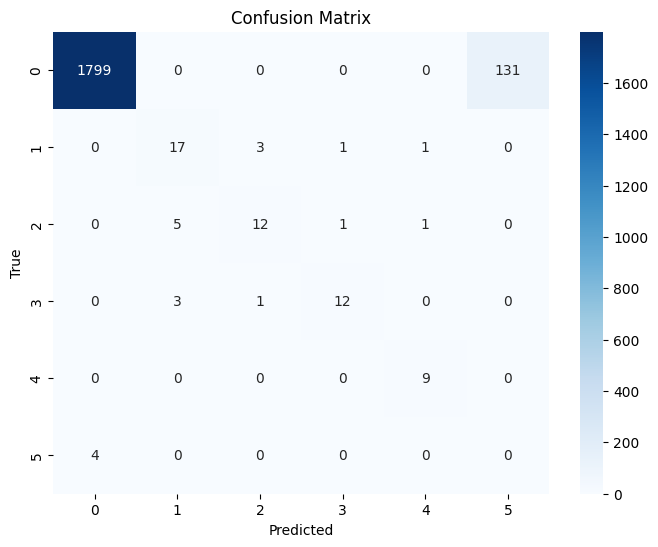

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
# --- Save Model and Preprocessors ---
joblib.dump(xgb_model, 'xgboost_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')

['pca.pkl']